In [1]:
import pandas as pd

# -----------------------------
# Load
# -----------------------------
df = pd.read_csv("ppr-group-24209891-train.csv")

# Get first n rows 一次只能2500行
m = 1
n = 2500
df = df.iloc[m-1:n]

# -----------------------------
# 1) Missing value report (count + %)
# -----------------------------
missing_summary = (
    pd.DataFrame({
        "missing_count": df.isna().sum(),
        "missing_pct": (df.isna().sum() / len(df) * 100).round(2)
    })
    .sort_values("missing_count", ascending=False)
)
print("Missing value summary:\n", missing_summary)

Missing value summary:
                            missing_count  missing_pct
Eircode                             2498        99.92
Property Size Description           2163        86.52
Date of Sale (dd/mm/yyyy)              0         0.00
Address                                0         0.00
County                                 0         0.00
Price (€)                              0         0.00
Not Full Market Price                  0         0.00
VAT Exclusive                          0         0.00
Description of Property                0         0.00


In [2]:
df = df.drop(columns=["Property Size Description"])
df.head()

,Date of Sale (dd/mm/yyyy),Address,County,Eircode,Price (€),Not Full Market Price,VAT Exclusive,Description of Property
0,22/12/2016,"LISMIHILL, KILLIMOR, BALLINASLOE",Galway,NaN,"€125,000.00",No,No,Second-Hand Dwelling house /Apartment
1,30/06/2016,"BARTON HOUSE, OLDTOWN, LETTERKENNY",Donegal,NaN,"€100,000.00",No,No,Second-Hand Dwelling house /Apartment
2,20/12/2016,"Apartment 84, Hampton Wood Avenue, Hampton Wood",Dublin,NaN,"€175,000.00",Yes,Yes,New Dwelling house /Apartment
3,24/05/2016,"8 THE BELFRY, COCK HILL, CHURCH VIEW",Cavan,NaN,"€65,000.00",No,No,Second-Hand Dwelling house /Apartment
4,22/08/2016,"8 THE PLACE, NEWCASTLE MANOR, NEWCASTLE",Dublin,NaN,"€190,000.00",No,No,Second-Hand Dwelling house /Apartment


  Indicator         Value
0      Mean    262.930492
1       Std    531.341044
2  Skewness     26.141470
3  Kurtosis    929.131193
4       Min      6.500000
5       Max  20800.000000
6    Median    190.250000


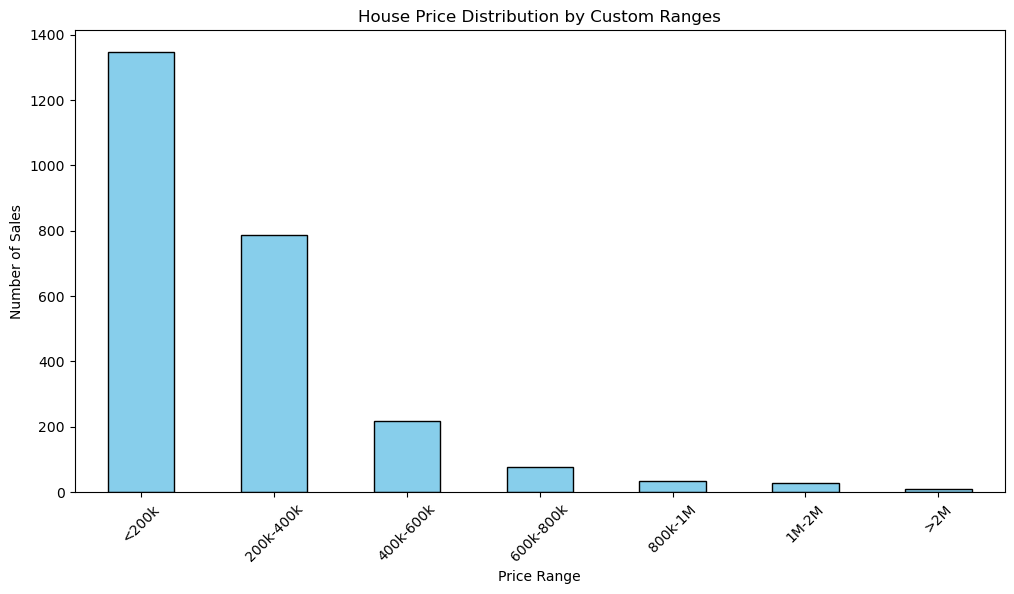

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. string to float
df['Price(1,000 €)'] = df['Price (€)'].replace(r'[€,]', '', regex=True).astype(float) / 1000
df['Price(1,000 €)'] = df['Price(1,000 €)'].round(2)

# 2. statistics summary for price
stats = {
    'Mean': df['Price(1,000 €)'].mean(),
    'Std': df['Price(1,000 €)'].std(),
    'Skewness': df['Price(1,000 €)'].skew(),
    'Kurtosis': df['Price(1,000 €)'].kurt(),
    'Min': df['Price(1,000 €)'].min(),
    'Max': df['Price(1,000 €)'].max(),
    'Median': df['Price(1,000 €)'].median()
}

stats_df = pd.DataFrame(stats.items(), columns=['Indicator', 'Value'])
print(stats_df)

# 3. lables for bins
bins = [0, 200, 400, 600, 800, 1000, 2000, float('inf')]
labels = ['<200k', '200k-400k', '400k-600k', '600k-800k', '800k-1M', '1M-2M', '>2M']

# 4. binning and calculating
df['Price_Range'] = pd.cut(df['Price(1,000 €)'], bins=bins, labels=labels)
counts = df['Price_Range'].value_counts().reindex(labels) # 保持顺序

# 5. visualization
plt.figure(figsize=(12, 6))
counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('House Price Distribution by Custom Ranges')
plt.ylabel('Number of Sales')
plt.xlabel('Price Range')
plt.xticks(rotation=45)
plt.show()

In [4]:
# calculate price threshold based on IQR method
Q1 = df['Price(1,000 €)'].quantile(0.25)
Q3 = df['Price(1,000 €)'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 0.5 * IQR
upper_bound = Q3 + 4 * IQR

print("lower_bound: ", lower_bound)
print("higher_bound: ", upper_bound)

lower_bound:  20.625
higher_bound:  1045.0


sample size: 2500
abnormal value: 60


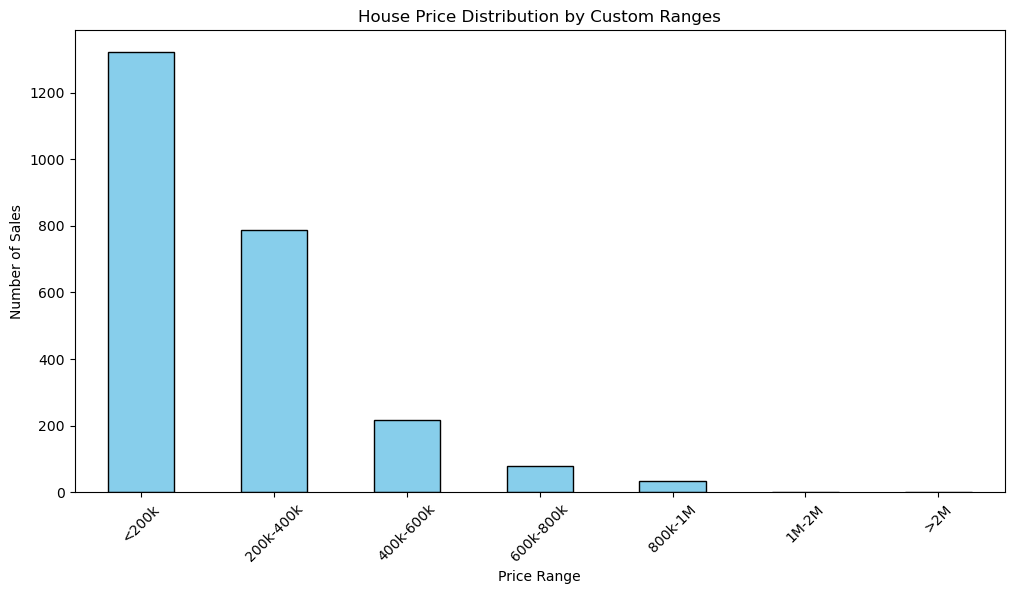

In [5]:
# 4. detect outliers
outliers = df[(df['Price(1,000 €)'] < lower_bound) | (df['Price(1,000 €)'] > upper_bound)]

print(f"sample size: {len(df)}")
print(f"abnormal value: {len(outliers)}")

df = df[(df['Price(1,000 €)'] >= lower_bound) & (df['Price(1,000 €)'] <= upper_bound)].copy()

# 5.binning and visualization
df['Price_Range'] = pd.cut(df['Price(1,000 €)'], bins=bins, labels=labels)
counts = df['Price_Range'].value_counts().reindex(labels) # 保持顺序

plt.figure(figsize=(12, 6))
counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('House Price Distribution by Custom Ranges')
plt.ylabel('Number of Sales')
plt.xlabel('Price Range')
plt.xticks(rotation=45)
plt.show()

In [6]:
# Year / Month / Quarter from sale date
# -----------------------------
df["Date of Sale"] = pd.to_datetime(
    df["Date of Sale (dd/mm/yyyy)"],
    format="%d/%m/%Y",
    errors="coerce"
)
df["sale_year"] = df["Date of Sale"].dt.year
df["sale_month"] = df["Date of Sale"].dt.month
df["sale_quarter"] = df["Date of Sale"].dt.quarter

# -----------------------------
# 5) Clean Price (€): remove €, commas, weird chars -> integer
# -----------------------------
# Keep only digits and decimal point, coerce invalid to NaN
price_numeric = pd.to_numeric(
    df["Price (€)"].astype(str).str.replace(r"[^0-9.]", "", regex=True),
    errors="coerce"
)

# Convert to integer euros (rounded to nearest euro). If you prefer floor: use .astype("Int64") directly after removing decimals.
df["price_eur"] = price_numeric.round().astype("Int64")

# (optional) drop original price string column
df = df.drop(columns=["Price (€)"])

# -----------------------------
# 6) Convert Yes/No columns to binary (Yes=1, No=0)
# -----------------------------
yn_map = {"Yes": 1, "No": 0}
df["Not Full Market Price"] = df["Not Full Market Price"].map(yn_map).astype("Int64")
df["VAT Exclusive"] = df["VAT Exclusive"].map(yn_map).astype("Int64")

# -----------------------------
# Quick sanity checks
# -----------------------------
print("\nData types snapshot:\n", df.dtypes)
print("\nPreview:\n", df.head())
print("\nRemaining missing values (top 10):\n", df.isna().sum().sort_values(ascending=False).head(10))



Data types snapshot:
 Date of Sale (dd/mm/yyyy)            object
Address                              object
County                               object
Eircode                              object
Not Full Market Price                 Int64
VAT Exclusive                         Int64
Description of Property              object
Price(1,000 €)                      float64
Price_Range                        category
Date of Sale                 datetime64[ns]
sale_year                             int32
sale_month                            int32
sale_quarter                          int32
price_eur                             Int64
dtype: object

Preview:
   Date of Sale (dd/mm/yyyy)                                          Address  \
0                22/12/2016                 LISMIHILL, KILLIMOR, BALLINASLOE   
1                30/06/2016               BARTON HOUSE, OLDTOWN, LETTERKENNY   
2                20/12/2016  Apartment 84, Hampton Wood Avenue, Hampton Wood   
3               

In [7]:
# ---------------------------------------
# Convert Description of Property to binary variable
# 1 = New property
# 0 = Second-hand property
# ---------------------------------------

# Step 1: standardize Irish and English labels
df["Description of Property"] = df["Description of Property"].replace({
    "Teach/Árasán Cónaithe Atháimhe": "Second-Hand Dwelling house /Apartment",
    "Teach/Árasán Cónaithe Nua": "New Dwelling house /Apartment"
})

# Step 2: create binary variable
df["is_new_property"] = (
    df["Description of Property"] == "New Dwelling house /Apartment"
).astype(int)

# Step 3: verify conversion
print(df["is_new_property"].value_counts())

# Step 4 (optional but recommended): drop original text column
df = df.drop(columns=["Description of Property"])

# Step 5: preview result
print(df[["is_new_property"]].head())

is_new_property
0    2163
1     337
Name: count, dtype: int64
   is_new_property
0                0
1                0
2                1
3                0
4                0


In [8]:
df.head(5)

,Date of Sale (dd/mm/yyyy),Address,County,Eircode,Not Full Market Price,VAT Exclusive,"Price(1,000 €)",Price_Range,Date of Sale,sale_year,sale_month,sale_quarter,price_eur,is_new_property
0,22/12/2016,"LISMIHILL, KILLIMOR, BALLINASLOE",Galway,NaN,0,0,125.0,<200k,2016-12-22,2016,12,4,125000,0
1,30/06/2016,"BARTON HOUSE, OLDTOWN, LETTERKENNY",Donegal,NaN,0,0,100.0,<200k,2016-06-30,2016,6,2,100000,0
2,20/12/2016,"Apartment 84, Hampton Wood Avenue, Hampton Wood",Dublin,NaN,1,1,175.0,<200k,2016-12-20,2016,12,4,175000,1
3,24/05/2016,"8 THE BELFRY, COCK HILL, CHURCH VIEW",Cavan,NaN,0,0,65.0,<200k,2016-05-24,2016,5,2,65000,0
4,22/08/2016,"8 THE PLACE, NEWCASTLE MANOR, NEWCASTLE",Dublin,NaN,0,0,190.0,<200k,2016-08-22,2016,8,3,190000,0


In [ ]:
import requests
import time
from tqdm import tqdm

API_KEY = "385f7a9df9ab4891ae0ca8a90f564467" # Your API Key 前往 https://opencagedata.com/ 注册后获得密钥

CSV_OUT = "with_lat_lng.csv" # 输出文件命名建议顺序命名

ADDRESS_COL = "Address"
COUNTY_COL = "County"

# Create empty columns
df["lat"] = None
df["lng"] = None

def geocode(address):
    url = "https://api.opencagedata.com/geocode/v1/json"
    params = {
        "q": address,
        "key": API_KEY,
        "countrycode": "ie",
        "limit": 1
    }
    response = requests.get(url, params=params)
    
    if response.status_code != 200:
        return None, None
    
    data = response.json()
    if data["results"]:
        lat = data["results"][0]["geometry"]["lat"]
        lng = data["results"][0]["geometry"]["lng"]
        return lat, lng
    return None, None

for i in tqdm(range(len(df))):
    address = str(df.loc[i, ADDRESS_COL]) + ", " + str(df.loc[i, COUNTY_COL]) + ", Ireland"
    
    lat, lng = geocode(address)
    
    df.loc[i, "lat"] = lat
    df.loc[i, "lng"] = lng
    
    time.sleep(1)  # IMPORTANT: avoid rate limit

 98%|████████████████████████████████████████████████████████████████████████████████████████▉  | 2443/2500 [55:00<01:06,  1.17s/it]

In [11]:
df.head(5)

,Date of Sale (dd/mm/yyyy),Address,County,Eircode,Not Full Market Price,VAT Exclusive,"Price(1,000 €)",Price_Range,Date of Sale,sale_year,sale_month,sale_quarter,price_eur,is_new_property,lat,lng
0,22/12/2016,"LISMIHILL, KILLIMOR, BALLINASLOE",Galway,NaN,0,0,125.0,<200k,2016-12-22,2016,12,4,125000,0,53.3275,-8.21944
1,30/06/2016,"BARTON HOUSE, OLDTOWN, LETTERKENNY",Donegal,NaN,0,0,100.0,<200k,2016-06-30,2016,6,2,100000,0,54.95,-7.73333
2,20/12/2016,"Apartment 84, Hampton Wood Avenue, Hampton Wood",Dublin,NaN,1,1,175.0,<200k,2016-12-20,2016,12,4,175000,1,53.33306,-6.24889
3,24/05/2016,"8 THE BELFRY, COCK HILL, CHURCH VIEW",Cavan,NaN,0,0,65.0,<200k,2016-05-24,2016,5,2,65000,0,53.99083,-7.36056
4,22/08/2016,"8 THE PLACE, NEWCASTLE MANOR, NEWCASTLE",Dublin,NaN,0,0,190.0,<200k,2016-08-22,2016,8,3,190000,0,53.296101,-6.492


In [13]:
from math import radians, sin, cos, sqrt, atan2

# =========================
# Config
# =========================
CSV_OUT = "with_distance_to_local_economic_center.csv"

COUNTY_COL = "County"   # change if your column name differs
LAT_COL    = "lat"      # must exist in your data (from geocoding)
LNG_COL    = "lng"      # must exist in your data (from geocoding)

OUT_COL = "distance_to_local_economic_center_km"

# =========================
# County -> local economic center (approx)
# =========================
# NOTE:
# - These are practical “center city/town” coordinates for each county.
# - If your county names differ (e.g., "Co. Dublin", "Dublin City"), the normalizer below helps.
county_center = {
    "carlo": (52.8365, -6.9341),          # Carlow
    "cavan": (53.9900, -7.3600),          # Cavan
    "clare": (52.6638, -8.6267),          # Limerick (strongest nearby hub); alternative: Ennis
    "cork": (51.8985, -8.4756),           # Cork
    "donegal": (54.6540, -8.1100),        # Letterkenny-ish region
    "dublin": (53.3498, -6.2603),         # Dublin
    "galway": (53.2707, -9.0568),         # Galway
    "kerry": (52.1545, -9.5669),          # Tralee/Killarney area
    "kildare": (53.1593, -6.9099),        # Naas
    "kilkenny": (52.6541, -7.2448),       # Kilkenny
    "laois": (53.0340, -7.2990),          # Portlaoise
    "leitrim": (54.1250, -8.0000),        # Carrick-on-Shannon area
    "limerick": (52.6638, -8.6267),       # Limerick
    "longford": (53.7275, -7.7930),       # Longford
    "louth": (53.9979, -6.4023),          # Dundalk/Drogheda corridor
    "mayo": (53.8550, -9.2980),           # Castlebar/Westport area
    "meath": (53.6055, -6.6564),          # Navan
    "monaghan": (54.2492, -6.9683),       # Monaghan
    "offaly": (53.2734, -7.7783),         # Tullamore
    "roscommon": (53.7598, -8.2682),      # Roscommon
    "sligo": (54.2766, -8.4761),          # Sligo
    "tipperary": (52.4738, -8.1557),      # Thurles/Cashel area
    "waterford": (52.2593, -7.1101),      # Waterford
    "westmeath": (53.5266, -7.3386),      # Mullingar/Athlone corridor
    "wexford": (52.3369, -6.4633),        # Wexford
    "wicklow": (52.9862, -6.3675),        # Wicklow
}

# Some datasets use "Laois" as "Queen's County" historically (rare); add aliases if needed.
county_alias = {
    "co dublin": "dublin",
    "county dublin": "dublin",
    "dublin city": "dublin",
    "co cork": "cork",
    "county cork": "cork",
    "co galway": "galway",
    "county galway": "galway",
    "co limerick": "limerick",
    "county limerick": "limerick",
    "co waterford": "waterford",
    "county waterford": "waterford",
}

def normalize_county(x) -> str:
    if pd.isna(x):
        return ""
    s = str(x).strip().lower()
    s = s.replace(".", "").replace(",", "")
    s = " ".join(s.split())
    # map aliases
    if s in county_alias:
        return county_alias[s]
    # also handle "co <name>"
    if s.startswith("co "):
        s2 = s[3:].strip()
        return county_alias.get(s, s2)
    if s.startswith("county "):
        return s[7:].strip()
    return s

# =========================
# Haversine distance (km)
# =========================
def haversine_km(lat1, lon1, lat2, lon2) -> float:
    R = 6371.0
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    return 2 * R * atan2(sqrt(a), sqrt(1 - a))

def compute_distance(row) -> float | None:
    lat = row.get(LAT_COL, None)
    lng = row.get(LNG_COL, None)
    if pd.isna(lat) or pd.isna(lng):
        return None

    county_raw = row.get(COUNTY_COL, "")
    county = normalize_county(county_raw)
    if not county:
        return None

    center = county_center.get(county)
    if center is None:
        return None

    c_lat, c_lng = center
    return haversine_km(float(lat), float(lng), c_lat, c_lng)

# =========================
# Run
# =========================

# Create distance feature
df[OUT_COL] = df.apply(compute_distance, axis=1)

df.head(5)
# Save
df.to_csv(CSV_OUT, index=False)
print(f"Saved: {CSV_OUT}")
print(df[[COUNTY_COL, LAT_COL, LNG_COL, OUT_COL]].head(10))

,Date of Sale (dd/mm/yyyy),Address,County,Eircode,Not Full Market Price,VAT Exclusive,"Price(1,000 €)",Price_Range,Date of Sale,sale_year,sale_month,sale_quarter,price_eur,is_new_property,lat,lng,distance_to_local_economic_center_km
0,22/12/2016,"LISMIHILL, KILLIMOR, BALLINASLOE",Galway,NaN,0,0,125.0,<200k,2016-12-22,2016,12,4,125000,0,53.3275,-8.21944,56.003110
1,30/06/2016,"BARTON HOUSE, OLDTOWN, LETTERKENNY",Donegal,NaN,0,0,100.0,<200k,2016-06-30,2016,6,2,100000,0,54.95,-7.73333,40.818330
2,20/12/2016,"Apartment 84, Hampton Wood Avenue, Hampton Wood",Dublin,NaN,1,1,175.0,<200k,2016-12-20,2016,12,4,175000,1,53.33306,-6.24889,2.009631
3,24/05/2016,"8 THE BELFRY, COCK HILL, CHURCH VIEW",Cavan,NaN,0,0,65.0,<200k,2016-05-24,2016,5,2,65000,0,53.99083,-7.36056,0.099288
4,22/08/2016,"8 THE PLACE, NEWCASTLE MANOR, NEWCASTLE",Dublin,NaN,0,0,190.0,<200k,2016-08-22,2016,8,3,190000,0,53.296101,-6.492,16.506682
